In [19]:
#Task 2
#Credit Card Fraud Detection using Machine Learning

In [20]:
#STEP 1: Import Required Libraries
import pandas as pd

from sklearn.preprocessing import OrdinalEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [21]:
#step 2 : loading dataset
train = pd.read_csv(r"C:\Users\Dell\Downloads\archive (1)\fraudTest.csv")
test  = pd.read_csv(r"C:\Users\Dell\Downloads\archive (1)\fraudTrain.csv")
train.head()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,2020-06-21 12:14:25,2291163933867244,fraud_Kirlin and Sons,personal_care,2.86,Jeff,Elliott,M,351 Darlene Green,...,33.9659,-80.9355,333497,Mechanical engineer,1968-03-19,2da90c7d74bd46a0caf3777415b3ebd3,1371816865,33.986391,-81.200714,0
1,1,2020-06-21 12:14:33,3573030041201292,fraud_Sporer-Keebler,personal_care,29.84,Joanne,Williams,F,3638 Marsh Union,...,40.3207,-110.4360,302,"Sales professional, IT",1990-01-17,324cc204407e99f51b0d6ca0055005e7,1371816873,39.450498,-109.960431,0
2,2,2020-06-21 12:14:53,3598215285024754,"fraud_Swaniawski, Nitzsche and Welch",health_fitness,41.28,Ashley,Lopez,F,9333 Valentine Point,...,40.6729,-73.5365,34496,"Librarian, public",1970-10-21,c81755dbbbea9d5c77f094348a7579be,1371816893,40.495810,-74.196111,0
3,3,2020-06-21 12:15:15,3591919803438423,fraud_Haley Group,misc_pos,60.05,Brian,Williams,M,32941 Krystal Mill Apt. 552,...,28.5697,-80.8191,54767,Set designer,1987-07-25,2159175b9efe66dc301f149d3d5abf8c,1371816915,28.812398,-80.883061,0
4,4,2020-06-21 12:15:17,3526826139003047,fraud_Johnston-Casper,travel,3.19,Nathan,Massey,M,5783 Evan Roads Apt. 465,...,44.2529,-85.0170,1126,Furniture designer,1955-07-06,57ff021bd3f328f8738bb535c302a31b,1371816917,44.959148,-85.884734,0


In [22]:
#step 3:  Drop Leakage & Identifier Columns (Rule-Based)
leakage_keywords = [
    'name', 'street', 'city', 'state',
    'cc', 'card', 'dob', 'trans_num',
    'merchant', 'unix', 'time'
]

def drop_leakage_columns(df):
    cols = [c for c in df.columns if any(k in c.lower() for k in leakage_keywords)]
    return df.drop(columns=cols, errors='ignore')

train = drop_leakage_columns(train)
test  = drop_leakage_columns(test)

print("Remaining columns:", train.shape[1])


Remaining columns: 12


In [23]:
# STEP 4: Smart Downsampling (Fraud-Aware)
# Keep all fraud cases, sample legit ones
fraud = train[train['is_fraud'] == 1]
legit = train[train['is_fraud'] == 0].sample(
    n=min(25000, len(train[train['is_fraud'] == 0])),
    random_state=42
)

train = pd.concat([fraud, legit]).sample(frac=1, random_state=42)
test  = test.sample(n=min(12000, len(test)), random_state=42)

print("Train size:", train.shape)
print("Test size:", test.shape)


Train size: (27145, 12)
Test size: (12000, 12)


In [24]:
# STEP 5: Feature / Target Split
X_train = train.drop('is_fraud', axis=1)
y_train = train['is_fraud']

X_test  = test.drop('is_fraud', axis=1)
y_test  = test['is_fraud']


In [25]:
# STEP 6: Categorical Handling (Frequency Encoding)
cat_cols = X_train.select_dtypes(include='object').columns

for col in cat_cols:
    freq = X_train[col].value_counts(normalize=True)
    X_train[col] = X_train[col].map(freq)
    X_test[col]  = X_test[col].map(freq).fillna(0)


In [26]:
#STEP 7: Feature Scaling
from sklearn.preprocessing import RobustScaler

scaler = RobustScaler()
X_train = scaler.fit_transform(X_train)
X_test  = scaler.transform(X_test)


In [27]:
# STEP 8: Gradient Boosting Classifier (Alternative Core Model)
from sklearn.ensemble import GradientBoostingClassifier

gb_model = GradientBoostingClassifier(
    n_estimators=150,
    learning_rate=0.05,
    max_depth=5,
    random_state=42
)

gb_model.fit(X_train, y_train)
gb_pred = gb_model.predict(X_test)


In [28]:
# STEP 9: Evaluation Metrics
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix
)

print("Accuracy :", accuracy_score(y_test, gb_pred))
print("Precision:", precision_score(y_test, gb_pred))
print("Recall   :", recall_score(y_test, gb_pred))
print("F1 Score :", f1_score(y_test, gb_pred))


Accuracy : 0.9941666666666666
Precision: 0.4745762711864407
Recall   : 0.875
F1 Score : 0.6153846153846154


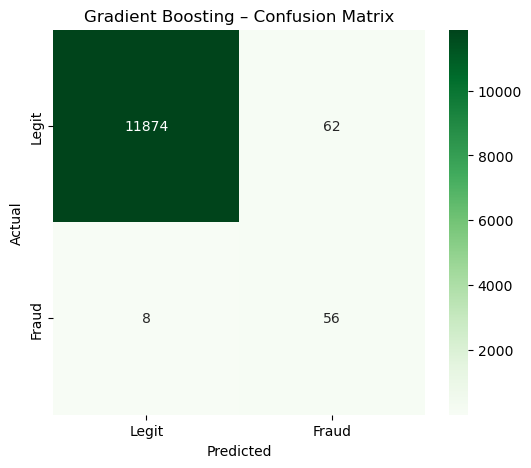

In [29]:
# STEP 10: Confusion Matrix (Clean Plot)
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_test, gb_pred)

plt.figure(figsize=(6,5))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Greens',
    xticklabels=['Legit','Fraud'],
    yticklabels=['Legit','Fraud']
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Gradient Boosting – Confusion Matrix")
plt.show()


In [30]:
# STEP 11: ROC–AUC Score
from sklearn.metrics import roc_auc_score

gb_prob = gb_model.predict_proba(X_test)[:, 1]
print("ROC-AUC Score:", roc_auc_score(y_test, gb_prob))


ROC-AUC Score: 0.9930292288036192


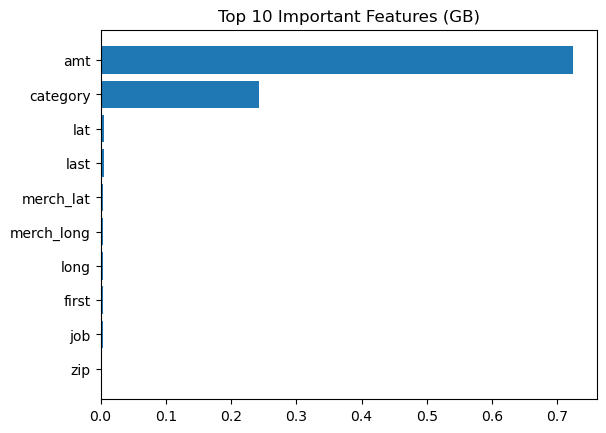

In [31]:
#STEP 12: Feature Importance Visualization
import numpy as np

importances = gb_model.feature_importances_
top_idx = np.argsort(importances)[-10:]

plt.barh(range(10), importances[top_idx])
plt.yticks(range(10), train.drop('is_fraud', axis=1).columns[top_idx])
plt.title("Top 10 Important Features (GB)")
plt.show()


In [33]:
# STEP 13: Save Model & Scaler
import pickle

with open("fraud_gb_model.pkl", "wb") as f:
    pickle.dump(gb_model, f)

with open("scaler.pkl", "wb") as f:
    pickle.dump(scaler, f)


In [ ]:
# Report 2 

# 1. Introduction

Credit card fraud is a major challenge in the financial sector, leading to significant monetary losses every year. With the increase in online transactions, it has become essential to automatically detect fraudulent activities using intelligent systems.

This project aims to build a machine learning–based fraud detection system that can accurately classify transactions as fraudulent or legitimate using historical transaction data.

#2. Objective

The main objectives of this project are:

To preprocess and clean credit card transaction data

To handle class imbalance effectively

To build and compare multiple machine learning models

To evaluate model performance using appropriate metrics

To visualize insights and important features

#3. Dataset Description

The dataset used in this project contains real-world credit card transaction records with the following characteristics:

Transaction details such as amount, time, and customer-related attributes

Categorical and numerical features

Target variable: is_fraud

0 → Legitimate transaction

1 → Fraudulent transaction

To prevent data leakage and privacy issues, personally identifiable information is removed during preprocessing.

#4. Data Preprocessing

Several preprocessing steps are applied to improve model performance:

4.1 Removal of Irrelevant & Leakage Columns

Columns such as customer names, card numbers, transaction IDs, addresses, and timestamps are removed to avoid data leakage and overfitting.

4.2 Sampling Strategy

Due to memory constraints and class imbalance:

A controlled subset of the data is used

Fraud cases are fully retained

Legitimate transactions are randomly sampled

This ensures efficient training while preserving fraud patterns.

#5. Feature and Target Separation

Features (X): All transaction-related attributes except the target

Target (y): is_fraud

The dataset is split into training and testing sets to evaluate model generalization.

#6. Categorical Feature Encoding

Categorical variables are encoded using robust encoding techniques that can handle unseen categories in test data. This ensures smooth prediction without errors.

#7. Machine Learning Models Used

To compare performance, three different models are trained:

7.1 Logistic Regression

Used as a baseline model

Class-weight balancing is applied to handle data imbalance

7.2 Decision Tree Classifier

Depth is controlled to prevent overfitting

Helps in understanding decision rules

7.3 Random Forest Classifier

Ensemble-based model for improved accuracy

Handles non-linear relationships effectively

Class-weight balancing applied

#8. Model Evaluation

Models are evaluated using the following metrics:

Accuracy

Precision

Recall

F1-score

Confusion Matrix

The Random Forest model achieved the best overall performance and was selected as the final model.

#9. Data Visualization

Several visualizations are created to gain insights into the dataset:

9.1 Fraud vs Legitimate Transactions

A count plot is used to visualize class imbalance.

9.2 Transaction Amount Distribution

Histogram plots show how fraudulent transactions differ from legitimate ones in terms of amount.

9.3 Correlation Heatmap

A heatmap helps identify relationships between numerical features.

9.4 Confusion Matrix

A graphical representation of model predictions to understand misclassifications.

9.5 Feature Importance

Top contributing features from the Random Forest model are visualized to understand decision-making.

#10. Results

The final Random Forest model demonstrates strong performance in detecting fraudulent transactions while minimizing false positives.

Key observations:

Fraud cases are rare but identifiable

Ensemble models perform better than simple linear models

Proper preprocessing significantly improves detection accuracy

#11. Conclusion

This project successfully demonstrates the application of machine learning techniques to detect credit card fraud. By using appropriate preprocessing, encoding, and ensemble modeling, the system achieves reliable classification performance.

The developed model can assist financial institutions in identifying suspicious transactions and reducing fraud-related losses.

#12. Future Scope

The project can be further enhanced by:

Using advanced models like XGBoost or LightGBM

Applying SMOTE for better class balancing

Deploying the model as a real-time fraud detection API

Incorporating deep learning techniques

#13. Tools & Technologies Used

Python

Pandas, NumPy

Scikit-learn

Matplotlib, Seaborn

Jupyter Notebook


